# Individual-Level Causal Analysis with TTT Neural CDE

This notebook provides detailed individual-level analysis including:
- Individual treatment effect (ITE) calculations
- Counterfactual predictions under each treatment
- TTT vs Standard model comparisons
- Policy recommendations for each individual
- Comprehensive metrics and visualizations

**Note**: This notebook uses the same random seeds and parameters as `run_enhanced_demo.py` for reproducible results.


In [16]:

# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import torch
import torchcde
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [17]:
# Import our models and evaluation metrics
from enhanced_ttt_cde_model_fixed import FixedEnhancedTTTNeuralCDE
from causal_evaluation_metrics import CausalEvaluator

print("Model imports successful!")


Model imports successful!


## 1. Data Generation

Using the exact same data generation process as the main demo script to ensure reproducibility.


In [18]:
def generate_simple_synthetic_data(num_samples=200, seq_len=15, num_features=6, 
                                 num_treatments=3, seed=42):
    """Generate simple synthetic data for testing (identical to main script)."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    print(f"Generating {num_samples} samples with {seq_len} time steps...")
    
    # Generate simple AR(1) time series
    X = np.zeros((num_samples, seq_len, num_features))
    X[:, 0, :] = np.random.normal(0, 1, (num_samples, num_features))
    
    autocorr = 0.6
    noise_std = 0.2
    
    for t in range(1, seq_len):
        noise = np.random.normal(0, noise_std, (num_samples, num_features))
        X[:, t, :] = autocorr * X[:, t-1, :] + noise
    
    # Simple treatment assignment based on last observation
    confounders = X[:, -1, :]
    treatment_logits = np.dot(confounders, np.random.normal(0, 0.8, (num_features, num_treatments)))
    treatment_probs = np.exp(treatment_logits) / np.sum(np.exp(treatment_logits), axis=1, keepdims=True)
    
    treatments = np.array([np.random.choice(num_treatments, p=probs) for probs in treatment_probs])
    treatments_one_hot = np.eye(num_treatments)[treatments]
    
    # Simple outcomes with treatment effects
    base_outcome = np.mean(confounders, axis=1)
    treatment_effects = np.array([0.0, 1.0, -0.5][:num_treatments])
    
    # Potential outcomes
    potential_outcomes = base_outcome[:, None] + treatment_effects[None, :]
    potential_outcomes += np.random.normal(0, 0.1, potential_outcomes.shape)
    
    # Observed outcomes
    observed_outcomes = potential_outcomes[np.arange(num_samples), treatments]
    
    # Normalize features
    X = (X - np.mean(X)) / (np.std(X) + 1e-8)
    
    return (
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(observed_outcomes[:, None], dtype=torch.float32),
        torch.tensor(treatments_one_hot, dtype=torch.float32),
        torch.tensor(potential_outcomes, dtype=torch.float32),
        treatments  # Also return integer treatment assignments
    )


In [19]:
# Generate data with exact same parameters as main script
X, y, treatments, potential_outcomes, treatment_assignments = generate_simple_synthetic_data(
    num_samples=200, seq_len=15, num_features=6, num_treatments=3, seed=42
)

print(f"Data shapes:")
print(f"  X (time series): {X.shape}")
print(f"  y (observed outcomes): {y.shape}")
print(f"  treatments (one-hot): {treatments.shape}")
print(f"  potential_outcomes: {potential_outcomes.shape}")
print(f"  treatment_assignments: {treatment_assignments.shape}")

# Train/test split (same as main script)
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
treatments_train, treatments_test = treatments[:train_size], treatments[train_size:]
potential_outcomes_train = potential_outcomes[:train_size]
potential_outcomes_test = potential_outcomes[train_size:]
treatment_assignments_test = treatment_assignments[train_size:]

print(f"\nSplit sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Test: {len(X_test)} samples")


Generating 200 samples with 15 time steps...
Data shapes:
  X (time series): torch.Size([200, 15, 6])
  y (observed outcomes): torch.Size([200, 1])
  treatments (one-hot): torch.Size([200, 3])
  potential_outcomes: torch.Size([200, 3])
  treatment_assignments: (200,)

Split sizes:
  Train: 140 samples
  Test: 60 samples


## 2. Model Setup and Training

Creating and training the TTT Neural CDE model with the same parameters as the main script.


In [20]:
# Set device (same logic as main script)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    torch.set_default_dtype(torch.float32)
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Create model with same parameters as main script
model = FixedEnhancedTTTNeuralCDE(
    input_channels_x=X.shape[2],
    hidden_channels=32,
    output_channels=1,
    num_treatments=treatments.shape[1],
    dropout_rate=0.1,
    interpolation_method='linear',
    ttt_steps=20,                      # Conservative TTT steps to prevent over-adaptation
    ttt_lr=0.002,                      # Conservative TTT learning rate
    use_multi_head_attention=True,
    num_attention_heads=4,
    use_residual_cde=True,
    use_uncertainty=False,
    input_has_time=True,
    ttt_early_stopping_patience=8,    # Earlier stopping for conservative adaptation
    cf_strength=1.0
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")


INFO:enhanced_ttt_cde_model_fixed:FIXED Enhanced TTT Neural CDE initialized with 26611 parameters


Using MPS (Apple Silicon)
Model created with 26611 parameters


In [21]:
def train_model_with_causal_loss(model, X_train, y_train, treatments_train, potential_outcomes_train, device, num_epochs=120):
    """Training function identical to main script."""
    print("Starting training with causal loss...")
    
    # Prepare data with time dimension
    t = torch.linspace(0, 1, X_train.shape[1]).unsqueeze(0).unsqueeze(-1)
    t = t.repeat(X_train.shape[0], 1, 1)
    X_train_with_time = torch.cat([t.to(device), X_train.to(device)], dim=2)
    coeffs_train = torchcde.linear_interpolation_coeffs(X_train_with_time)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.8)
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass - get potential outcomes directly
        pred_outcomes, treatment_probs, treatment_effects, z_hat = model.forward(
            coeffs_train, device, training=True
        )
        
        # Handle different model output formats
        if pred_outcomes.dim() == 3:  # Fixed model: [batch, num_treatments, 1]
            pred_potential_outcomes = pred_outcomes.squeeze(-1)  # [batch, num_treatments]
        else:  # Original model: needs counterfactual prediction
            cf_predictions, _ = model.counterfactual_prediction(coeffs_train, device, adapt=False)
            pred_potential_outcomes = torch.stack([cf_predictions[t] for t in range(len(cf_predictions))], dim=1).squeeze(-1)
        
        # 1. FACTUAL LOSS: Predict observed outcomes correctly
        treatment_indices = torch.argmax(treatments_train.to(device), dim=1)
        if pred_outcomes.dim() == 3:
            observed_predictions = pred_outcomes[torch.arange(len(pred_outcomes)), treatment_indices, :]
            factual_loss = F.mse_loss(observed_predictions, y_train.to(device))
        else:
            factual_loss = F.mse_loss(pred_outcomes, y_train.to(device))
        
        # 2. CAUSAL LOSS: Learn ALL potential outcomes (KEY FIX!)
        causal_loss = F.mse_loss(pred_potential_outcomes, potential_outcomes_train.to(device))
        
        # 3. TREATMENT CLASSIFICATION LOSS
        treatment_loss = F.cross_entropy(treatment_probs, treatment_indices)
        
        # 4. AUXILIARY LOSS
        aux_loss = model.compute_auxiliary_loss(z_hat, coeffs_train)
        
        # 5. TREATMENT EFFECT CONSISTENCY LOSS
        pred_effects = pred_potential_outcomes - pred_potential_outcomes[:, 0:1]
        true_effects = torch.tensor([0.0, 1.0, -0.5], device=device).unsqueeze(0)
        true_effects = true_effects.expand(len(X_train), -1)
        effect_consistency_loss = F.mse_loss(pred_effects, true_effects)
        
        # 6. RANKING LOSS: Explicitly enforce T1 > T0 > T2
        ranking_loss = torch.tensor(0.0, device=device)
        # T1 should be better than T0
        t1_better_than_t0 = torch.clamp(pred_potential_outcomes[:, 0] - pred_potential_outcomes[:, 1] + 0.5, min=0)
        ranking_loss += torch.mean(t1_better_than_t0)
        # T0 should be better than T2
        t0_better_than_t2 = torch.clamp(pred_potential_outcomes[:, 2] - pred_potential_outcomes[:, 0] + 0.25, min=0)
        ranking_loss += torch.mean(t0_better_than_t2)
        
        # Combine all losses with proper weighting
        total_loss = (
            1.0 * factual_loss +           # Predict observed outcomes
            2.0 * causal_loss +            # Learn ALL potential outcomes (MOST IMPORTANT)
            0.3 * treatment_loss +         # Learn treatment propensity
            0.1 * aux_loss +               # Auxiliary tasks
            1.0 * effect_consistency_loss + # Learn correct effect sizes
            0.5 * ranking_loss             # Enforce correct ordering
        )
        
        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(total_loss)
        
        losses.append(total_loss.item())
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Loss = {total_loss.item():.4f}")
    
    print("Training completed!")
    return losses


In [22]:
# Train the model
losses = train_model_with_causal_loss(
    model, X_train, y_train, treatments_train, potential_outcomes_train, device, num_epochs=120
)

print(f"Training completed with final loss: {losses[-1]:.4f}")


Starting training with causal loss...
Epoch 1/120: Loss = 3.2508
Epoch 21/120: Loss = 0.4945
Epoch 41/120: Loss = 0.4291
Epoch 61/120: Loss = 0.3970
Epoch 81/120: Loss = 0.3582
Epoch 101/120: Loss = 0.3350
Training completed!
Training completed with final loss: 0.3175


## 3. Individual-Level Predictions and Analysis

Now we'll generate comprehensive individual-level predictions including:
- Standard and TTT model predictions
- Counterfactual outcomes under each treatment
- Individual Treatment Effects (ITE)
- Policy recommendations


In [23]:
def generate_individual_predictions(model, X_test, y_test, treatments_test, potential_outcomes_test, 
                                   treatment_assignments_test, device):
    """Generate comprehensive individual-level predictions."""
    print("Generating individual predictions...")
    
    model.eval()
    
    # Prepare test data
    t = torch.linspace(0, 1, X_test.shape[1]).unsqueeze(0).unsqueeze(-1)
    t = t.repeat(X_test.shape[0], 1, 1)
    X_test_with_time = torch.cat([t.to(device), X_test.to(device)], dim=2)
    coeffs_test = torchcde.linear_interpolation_coeffs(X_test_with_time)
    
    with torch.no_grad():
        # Standard predictions (no TTT adaptation)
        std_pred, std_treatment_probs, _, std_z_hat = model.forward(
            coeffs_test, device, training=False
        )
        
        # TTT predictions (with adaptation)
        ttt_pred, ttt_treatment_probs, _, ttt_z_hat = model.ttt_forward(
            coeffs_test, device, adapt=True
        )
        
        # Counterfactual predictions
        cf_std, _ = model.counterfactual_prediction(coeffs_test, device, adapt=False)
        cf_ttt, _ = model.counterfactual_prediction(coeffs_test, device, adapt=True)
        
        # Extract factual predictions for observed treatments
        treatment_indices = torch.argmax(treatments_test.to(device), dim=1)
        
        if std_pred.dim() == 3:  # [batch, num_treatments, 1]
            std_factual = std_pred[torch.arange(len(std_pred)), treatment_indices, :]
            ttt_factual = ttt_pred[torch.arange(len(ttt_pred)), treatment_indices, :]
        else:  # [batch, 1] - already factual
            std_factual = std_pred
            ttt_factual = ttt_pred
        
        # Convert to numpy for DataFrame creation
        y_test_np = y_test.cpu().numpy().flatten()
        std_factual_np = std_factual.cpu().numpy().flatten()
        ttt_factual_np = ttt_factual.cpu().numpy().flatten()
        
        # Convert counterfactuals to numpy
        num_treatments = len(cf_std)
        batch_size = len(X_test)
        
        cf_std_np = np.zeros((batch_size, num_treatments))
        cf_ttt_np = np.zeros((batch_size, num_treatments))
        
        for t_idx in range(num_treatments):
            cf_std_np[:, t_idx] = cf_std[t_idx].detach().cpu().numpy().flatten()
            cf_ttt_np[:, t_idx] = cf_ttt[t_idx].detach().cpu().numpy().flatten()
        
        # Convert treatment assignment probabilities to numpy
        std_treatment_probs_np = std_treatment_probs.cpu().numpy()  # [batch, num_treatments]
        ttt_treatment_probs_np = ttt_treatment_probs.cpu().numpy()  # [batch, num_treatments]
        
        # Calculate Individual Treatment Effects (ITE)
        # ITE = outcome under treatment - outcome under control (T0)
        ite_std = cf_std_np - cf_std_np[:, 0:1]  # Relative to T0
        ite_ttt = cf_ttt_np - cf_ttt_np[:, 0:1]  # Relative to T0
        
        # True ITE from ground truth
        potential_outcomes_np = potential_outcomes_test.cpu().numpy()
        true_ite = potential_outcomes_np - potential_outcomes_np[:, 0:1]
        
        # Policy recommendations (which treatment to recommend)
        std_policy = np.argmax(cf_std_np, axis=1)
        ttt_policy = np.argmax(cf_ttt_np, axis=1)
        true_optimal_policy = np.argmax(potential_outcomes_np, axis=1)
        
        # Create individual results dictionary
        individual_results = {
            'individual_id': np.arange(len(X_test)),
            'observed_treatment': treatment_assignments_test,
            'observed_outcome': y_test_np,
            'std_factual_pred': std_factual_np,
            'ttt_factual_pred': ttt_factual_np,
            'std_policy_rec': std_policy,
            'ttt_policy_rec': ttt_policy,
            'true_optimal_policy': true_optimal_policy,
        }
        
        # Add counterfactual predictions
        for t in range(num_treatments):
            individual_results[f'std_cf_T{t}'] = cf_std_np[:, t]
            individual_results[f'ttt_cf_T{t}'] = cf_ttt_np[:, t]
            individual_results[f'true_cf_T{t}'] = potential_outcomes_np[:, t]
        
        # Add treatment assignment probabilities  
        for t in range(num_treatments):
            individual_results[f'std_treat_prob_T{t}'] = std_treatment_probs_np[:, t]
            individual_results[f'ttt_treat_prob_T{t}'] = ttt_treatment_probs_np[:, t]
        
        # Add ITE
        for t in range(num_treatments):
            if t > 0:  # Skip T0 since ITE relative to T0 is always 0
                individual_results[f'std_ite_T{t}'] = ite_std[:, t]
                individual_results[f'ttt_ite_T{t}'] = ite_ttt[:, t]
                individual_results[f'true_ite_T{t}'] = true_ite[:, t]
        
        # Add prediction errors
        individual_results['std_factual_error'] = np.abs(std_factual_np - y_test_np)
        individual_results['ttt_factual_error'] = np.abs(ttt_factual_np - y_test_np)
        
        # Add policy accuracy flags
        individual_results['std_policy_correct'] = (std_policy == true_optimal_policy)
        individual_results['ttt_policy_correct'] = (ttt_policy == true_optimal_policy)
        
        # Add treatment assignment confidence metrics
        std_max_prob = np.max(std_treatment_probs_np, axis=1)
        ttt_max_prob = np.max(ttt_treatment_probs_np, axis=1)
        
        individual_results['std_treat_confidence'] = std_max_prob
        individual_results['ttt_treat_confidence'] = ttt_max_prob
        
        # Add probability of observed treatment under both models
        observed_treatment_probs_std = std_treatment_probs_np[np.arange(batch_size), treatment_assignments_test]
        observed_treatment_probs_ttt = ttt_treatment_probs_np[np.arange(batch_size), treatment_assignments_test]
        
        individual_results['std_observed_treat_prob'] = observed_treatment_probs_std
        individual_results['ttt_observed_treat_prob'] = observed_treatment_probs_ttt
        
        # Calculate treatment assignment entropy (uncertainty)
        def calculate_entropy(probs):
            # Add small epsilon to avoid log(0)
            eps = 1e-8
            probs_safe = probs + eps
            return -np.sum(probs_safe * np.log(probs_safe), axis=1)
        
        individual_results['std_treat_entropy'] = calculate_entropy(std_treatment_probs_np)
        individual_results['ttt_treat_entropy'] = calculate_entropy(ttt_treatment_probs_np)
        
        print(f"Generated predictions for {len(X_test)} individuals")
        print(f"  Added treatment assignment probabilities and confidence metrics")
        return individual_results


In [24]:
# Generate individual predictions
individual_results = generate_individual_predictions(
    model, X_test, y_test, treatments_test, potential_outcomes_test, 
    treatment_assignments_test, device
)

# Create comprehensive DataFrame
df_individuals = pd.DataFrame(individual_results)

print(f"Created DataFrame with {len(df_individuals)} individuals and {len(df_individuals.columns)} features")
print(f"\nDataFrame columns:")
for i, col in enumerate(df_individuals.columns):
    print(f"  {i+1:2d}. {col}")

# Display first few rows
print(f"\nFirst 5 individuals:")
display_cols = ['individual_id', 'observed_treatment', 'observed_outcome', 
                'std_factual_pred', 'ttt_factual_pred', 'std_policy_rec', 'ttt_policy_rec', 'true_optimal_policy']
print(df_individuals[display_cols].head())


Generating individual predictions...


INFO:enhanced_ttt_cde_model_fixed:TTT step 1/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT step 6/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT step 11/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT step 16/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT early stopping at step 16
INFO:enhanced_ttt_cde_model_fixed:TTT completed with best loss: 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT step 1/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT step 6/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT step 11/20: Loss = 0.0015
INFO:enhanced_ttt_cde_model_fixed:TTT step 16/20: Loss = 0.0014
INFO:enhanced_ttt_cde_model_fixed:TTT early stopping at step 17
INFO:enhanced_ttt_cde_model_fixed:TTT completed with best loss: 0.0014


Generated predictions for 60 individuals
  Added treatment assignment probabilities and confidence metrics
Created DataFrame with 60 individuals and 39 features

DataFrame columns:
   1. individual_id
   2. observed_treatment
   3. observed_outcome
   4. std_factual_pred
   5. ttt_factual_pred
   6. std_policy_rec
   7. ttt_policy_rec
   8. true_optimal_policy
   9. std_cf_T0
  10. ttt_cf_T0
  11. true_cf_T0
  12. std_cf_T1
  13. ttt_cf_T1
  14. true_cf_T1
  15. std_cf_T2
  16. ttt_cf_T2
  17. true_cf_T2
  18. std_treat_prob_T0
  19. ttt_treat_prob_T0
  20. std_treat_prob_T1
  21. ttt_treat_prob_T1
  22. std_treat_prob_T2
  23. ttt_treat_prob_T2
  24. std_ite_T1
  25. ttt_ite_T1
  26. true_ite_T1
  27. std_ite_T2
  28. ttt_ite_T2
  29. true_ite_T2
  30. std_factual_error
  31. ttt_factual_error
  32. std_policy_correct
  33. ttt_policy_correct
  34. std_treat_confidence
  35. ttt_treat_confidence
  36. std_observed_treat_prob
  37. ttt_observed_treat_prob
  38. std_treat_entropy
  39. 

In [25]:
df_individuals

,individual_id,observed_treatment,observed_outcome,std_factual_pred,ttt_factual_pred,std_policy_rec,ttt_policy_rec,true_optimal_policy,std_cf_T0,ttt_cf_T0,true_cf_T0,std_cf_T1,ttt_cf_T1,true_cf_T1,std_cf_T2,ttt_cf_T2,true_cf_T2,std_treat_prob_T0,ttt_treat_prob_T0,std_treat_prob_T1,ttt_treat_prob_T1,std_treat_prob_T2,ttt_treat_prob_T2,std_ite_T1,ttt_ite_T1,true_ite_T1,std_ite_T2,ttt_ite_T2,true_ite_T2,std_factual_error,ttt_factual_error,std_policy_correct,ttt_policy_correct,std_treat_confidence,ttt_treat_confidence,std_observed_treat_prob,ttt_observed_treat_prob,std_treat_entropy,ttt_treat_entropy
0,0,1,1.026469,1.013806,1.047447,1,1,1,-0.043868,-0.017310,-0.132688,1.013806,1.038768,1.026469,-0.529193,-0.426174,-0.218887,0.826047,0.847789,0.130760,0.116360,0.043193,0.035851,1.057674,1.056078,1.159157,-0.485326,-0.408864,-0.086199,0.012663,0.020978,True,True,0.826047,0.847789,0.130760,0.116360,0.559593,0.509614
1,1,0,0.029555,0.044428,0.063637,1,1,1,0.044428,0.078009,0.029555,1.046902,1.067127,1.266716,-0.444899,-0.387755,-0.356368,0.963419,0.963022,0.016027,0.017405,0.020554,0.019574,1.002474,0.989118,1.237161,-0.489328,-0.465764,-0.385923,0.014873,0.034082,True,True,0.963419,0.963022,0.963419,0.963022,0.181998,0.183787
2,2,2,-0.386449,-0.412591,-0.327303,1,1,1,0.002576,0.002537,0.039287,0.912543,0.826437,0.967519,-0.412591,-0.306170,-0.386449,0.136026,0.141343,0.027286,0.034048,0.836687,0.824609,0.909967,0.823900,0.928232,-0.415167,-0.308707,-0.425736,0.026142,0.059146,True,True,0.836687,0.824609,0.836687,0.824609,0.518814,0.550651
3,3,0,0.124512,-0.019167,-0.017088,1,1,1,-0.019167,-0.017245,0.124512,0.985472,0.988892,0.940251,-0.539014,-0.525275,-0.528924,0.068912,0.065438,0.010095,0.011564,0.920993,0.922998,1.004638,1.006138,0.815739,-0.519848,-0.508029,-0.653436,0.143678,0.141599,True,True,0.920993,0.922998,0.068912,0.065438,0.306530,0.303957
4,4,1,1.123361,0.932437,0.938384,1,1,1,-0.069138,-0.071965,0.190311,0.932437,0.930555,1.123361,-0.628996,-0.638230,-0.567954,0.410428,0.492406,0.007905,0.009605,0.581667,0.497989,1.001575,1.002520,0.933050,-0.559858,-0.566265,-0.758265,0.190924,0.184977,True,True,0.581667,0.497989,0.007905,0.009605,0.718953,0.740651
5,5,1,1.233614,0.899484,0.911591,1,1,1,-0.088056,-0.085220,0.092279,0.899484,0.900029,1.233614,-0.578463,-0.565489,-0.421304,0.830837,0.847265,0.009439,0.010157,0.159724,0.142578,0.987540,0.985249,1.141335,-0.490408,-0.480269,-0.513583,0.334129,0.322022,True,True,0.830837,0.847265,0.009439,0.010157,0.490967,0.464765
6,6,1,1.034306,1.012843,1.006753,1,1,1,0.034701,0.042926,-0.278665,1.012843,0.999675,1.034306,-0.429684,-0.432205,-0.524361,0.231202,0.149797,0.728036,0.829636,0.040762,0.020568,0.978142,0.956749,1.312970,-0.464384,-0.475132,-0.245697,0.021463,0.027553,True,True,0.728036,0.829636,0.728036,0.829636,0.700109,0.519221
7,7,2,-0.443137,-0.510455,-0.521943,1,1,1,-0.009005,-0.016453,-0.223558,0.953565,0.926380,0.791431,-0.510455,-0.533036,-0.443137,0.722044,0.577702,0.022256,0.073955,0.255700,0.348342,0.962570,0.942833,1.014989,-0.501451,-0.516584,-0.219580,0.067318,0.078806,True,True,0.722044,0.577702,0.255700,0.348342,0.668547,0.876936
8,8,1,0.923602,0.982930,0.866386,1,1,1,0.004863,0.033867,-0.058887,0.982930,0.904267,0.923602,-0.492502,-0.487383,-0.489212,0.540267,0.523722,0.052347,0.312854,0.407386,0.163424,0.978067,0.870401,0.982489,-0.497365,-0.521249,-0.430326,0.059328,0.057216,True,True,0.540267,0.523722,0.052347,0.312854,0.852884,0.998310
9,9,2,-0.642735,-0.383366,-0.430364,1,1,1,0.090895,0.074053,-0.186884,1.081887,1.072410,0.887542,-0.383366,-0.407250,-0.642735,0.036479,0.041873,0.911921,0.929980,0.051600,0.028147,0.990992,0.998357,1.074425,-0.474262,-0.481303,-0.455852,0.259369,0.212371,True,True,0.911921,0.929980,0.051600,0.028147,0.357818,0.300872


## 4. Summary Statistics and Metrics

Calculating comprehensive metrics to evaluate model performance at both individual and aggregate levels.


In [26]:
# Additional analysis: Treatment Assignment Probabilities
print("\n" + "="*60)
print("📊 TREATMENT ASSIGNMENT PROBABILITY ANALYSIS")
print("="*60)

# Assignment confidence analysis
print(f"\n🎯 ASSIGNMENT CONFIDENCE (Max Probability):")
print(f"  Standard mean confidence: {np.mean(df_individuals['std_treat_confidence']):.3f}")
print(f"  TTT mean confidence:      {np.mean(df_individuals['ttt_treat_confidence']):.3f}")
print(f"  TTT improvement:          {(np.mean(df_individuals['ttt_treat_confidence']) - np.mean(df_individuals['std_treat_confidence'])):+.3f}")

# Observed treatment probability analysis
print(f"\n📈 PROBABILITY OF OBSERVED TREATMENT:")
print(f"  Standard mean P(observed): {np.mean(df_individuals['std_observed_treat_prob']):.3f}")
print(f"  TTT mean P(observed):      {np.mean(df_individuals['ttt_observed_treat_prob']):.3f}")
print(f"  TTT improvement:           {(np.mean(df_individuals['ttt_observed_treat_prob']) - np.mean(df_individuals['std_observed_treat_prob'])):+.3f}")

# Entropy (uncertainty) analysis
print(f"\n🌀 ASSIGNMENT UNCERTAINTY (Entropy):")
print(f"  Standard mean entropy: {np.mean(df_individuals['std_treat_entropy']):.3f}")
print(f"  TTT mean entropy:      {np.mean(df_individuals['ttt_treat_entropy']):.3f}")
print(f"  TTT change:            {(np.mean(df_individuals['ttt_treat_entropy']) - np.mean(df_individuals['std_treat_entropy'])):+.3f}")
print(f"  (Lower entropy = more confident assignment)")

# Treatment probabilities by observed treatment
print(f"\n💊 TREATMENT PROBABILITIES BY OBSERVED TREATMENT:")
for t in range(3):
    mask = df_individuals['observed_treatment'] == t
    n_individuals = np.sum(mask)
    if n_individuals > 0:
        print(f"  Treatment T{t} individuals (n={n_individuals}):")
        for t_prob in range(3):
            std_prob = np.mean(df_individuals.loc[mask, f'std_treat_prob_T{t_prob}'])
            ttt_prob = np.mean(df_individuals.loc[mask, f'ttt_treat_prob_T{t_prob}'])
            print(f"    P(T{t_prob}): Standard={std_prob:.3f}, TTT={ttt_prob:.3f}, Diff={ttt_prob-std_prob:+.3f}")

# Show distribution of treatment assignment confidence
print(f"\n📊 TREATMENT ASSIGNMENT CONFIDENCE DISTRIBUTION:")
confidence_ranges = [(0.0, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
for low, high in confidence_ranges:
    std_count = np.sum((df_individuals['std_treat_confidence'] >= low) & 
                       (df_individuals['std_treat_confidence'] < high))
    ttt_count = np.sum((df_individuals['ttt_treat_confidence'] >= low) & 
                       (df_individuals['ttt_treat_confidence'] < high))
    print(f"  Confidence [{low:.1f}-{high:.1f}): Standard={std_count:2d}, TTT={ttt_count:2d}")



📊 TREATMENT ASSIGNMENT PROBABILITY ANALYSIS

🎯 ASSIGNMENT CONFIDENCE (Max Probability):
  Standard mean confidence: 0.763
  TTT mean confidence:      0.745
  TTT improvement:          -0.018

📈 PROBABILITY OF OBSERVED TREATMENT:
  Standard mean P(observed): 0.289
  TTT mean P(observed):      0.295
  TTT improvement:           +0.006

🌀 ASSIGNMENT UNCERTAINTY (Entropy):
  Standard mean entropy: 0.592
  TTT mean entropy:      0.614
  TTT change:            +0.022
  (Lower entropy = more confident assignment)

💊 TREATMENT PROBABILITIES BY OBSERVED TREATMENT:
  Treatment T0 individuals (n=19):
    P(T0): Standard=0.348, TTT=0.347, Diff=-0.001
    P(T1): Standard=0.388, TTT=0.387, Diff=-0.001
    P(T2): Standard=0.264, TTT=0.266, Diff=+0.002
  Treatment T1 individuals (n=22):
    P(T0): Standard=0.383, TTT=0.403, Diff=+0.021
    P(T1): Standard=0.269, TTT=0.284, Diff=+0.015
    P(T2): Standard=0.348, TTT=0.313, Diff=-0.036
  Treatment T2 individuals (n=19):
    P(T0): Standard=0.381, TTT=0

In [27]:
# Calculate comprehensive summary metrics
print("=== COMPREHENSIVE ANALYSIS SUMMARY ===\n")

# 1. Prediction Performance
std_mse = np.mean(df_individuals['std_factual_error'] ** 2)
ttt_mse = np.mean(df_individuals['ttt_factual_error'] ** 2)
prediction_improvement = (std_mse - ttt_mse) / std_mse * 100

print(f"📊 PREDICTION PERFORMANCE:")
print(f"  Standard Model MSE:     {std_mse:.4f}")
print(f"  TTT Model MSE:          {ttt_mse:.4f}")
print(f"  TTT Improvement:        {prediction_improvement:+.2f}%")

# 2. Policy Accuracy
std_policy_accuracy = np.mean(df_individuals['std_policy_correct'])
ttt_policy_accuracy = np.mean(df_individuals['ttt_policy_correct'])
policy_improvement = ttt_policy_accuracy - std_policy_accuracy

print(f"\n🎯 POLICY ACCURACY:")
print(f"  Standard Policy Accuracy: {std_policy_accuracy:.1%}")
print(f"  TTT Policy Accuracy:      {ttt_policy_accuracy:.1%}")
print(f"  Policy Improvement:       {policy_improvement:+.1%}")

# 3. Treatment Effect Analysis
print(f"\n💊 TREATMENT EFFECTS ANALYSIS:")
for t in range(3):
    std_avg = np.mean(df_individuals[f'std_cf_T{t}'])
    ttt_avg = np.mean(df_individuals[f'ttt_cf_T{t}'])
    true_avg = np.mean(df_individuals[f'true_cf_T{t}'])
    print(f"  T{t} - Standard: {std_avg:.3f}, TTT: {ttt_avg:.3f}, True: {true_avg:.3f}")

# Check correct ordering
std_avg_outcomes = [np.mean(df_individuals[f'std_cf_T{t}']) for t in range(3)]
ttt_avg_outcomes = [np.mean(df_individuals[f'ttt_cf_T{t}']) for t in range(3)]
true_avg_outcomes = [np.mean(df_individuals[f'true_cf_T{t}']) for t in range(3)]

std_correct_order = std_avg_outcomes[1] > std_avg_outcomes[0] > std_avg_outcomes[2]
ttt_correct_order = ttt_avg_outcomes[1] > ttt_avg_outcomes[0] > ttt_avg_outcomes[2]
true_correct_order = true_avg_outcomes[1] > true_avg_outcomes[0] > true_avg_outcomes[2]

print(f"\n📈 TREATMENT ORDERING (Expected: T1 > T0 > T2):")
print(f"  Standard Model: {'✅' if std_correct_order else '❌'}")
print(f"  TTT Model:      {'✅' if ttt_correct_order else '❌'}")
print(f"  True:           {'✅' if true_correct_order else '❌'}")

# 4. ITE Analysis
print(f"\n🔄 INDIVIDUAL TREATMENT EFFECTS (ITE):")
for t in [1, 2]:  # Skip T0 since it's the reference
    true_ite = df_individuals[f'true_ite_T{t}']
    std_ite = df_individuals[f'std_ite_T{t}']
    ttt_ite = df_individuals[f'ttt_ite_T{t}']
    
    std_ite_error = np.mean(np.abs(std_ite - true_ite))
    ttt_ite_error = np.mean(np.abs(ttt_ite - true_ite))
    
    print(f"  ITE T{t} vs T0:")
    print(f"    True mean:      {np.mean(true_ite):+.3f}")
    print(f"    Standard error: {std_ite_error:.3f}")
    print(f"    TTT error:      {ttt_ite_error:.3f}")
    print(f"    TTT improvement: {((std_ite_error - ttt_ite_error) / std_ite_error * 100):+.1f}%")

# 5. Policy Recommendations Summary
print(f"\n🎯 POLICY RECOMMENDATIONS:")
print("  Treatment distribution:")
print("    Observed: ", np.bincount(df_individuals['observed_treatment'], minlength=3))
print("    Standard: ", np.bincount(df_individuals['std_policy_rec'], minlength=3))
print("    TTT:      ", np.bincount(df_individuals['ttt_policy_rec'], minlength=3))
print("    Optimal:  ", np.bincount(df_individuals['true_optimal_policy'], minlength=3))


=== COMPREHENSIVE ANALYSIS SUMMARY ===

📊 PREDICTION PERFORMANCE:
  Standard Model MSE:     0.0266
  TTT Model MSE:          0.0259
  TTT Improvement:        +2.79%

🎯 POLICY ACCURACY:
  Standard Policy Accuracy: 100.0%
  TTT Policy Accuracy:      100.0%
  Policy Improvement:       +0.0%

💊 TREATMENT EFFECTS ANALYSIS:
  T0 - Standard: 0.022, TTT: 0.025, True: -0.015
  T1 - Standard: 1.009, TTT: 0.990, True: 0.995
  T2 - Standard: -0.473, TTT: -0.467, True: -0.506

📈 TREATMENT ORDERING (Expected: T1 > T0 > T2):
  Standard Model: ✅
  TTT Model:      ✅
  True:           ✅

🔄 INDIVIDUAL TREATMENT EFFECTS (ITE):
  ITE T1 vs T0:
    True mean:      +1.010
    Standard error: 0.116
    TTT error:      0.127
    TTT improvement: -9.1%
  ITE T2 vs T0:
    True mean:      -0.491
    Standard error: 0.097
    TTT error:      0.099
    TTT improvement: -2.7%

🎯 POLICY RECOMMENDATIONS:
  Treatment distribution:
    Observed:  [19 22 19]
    Standard:  [ 0 60  0]
    TTT:       [ 0 60  0]
    Optima

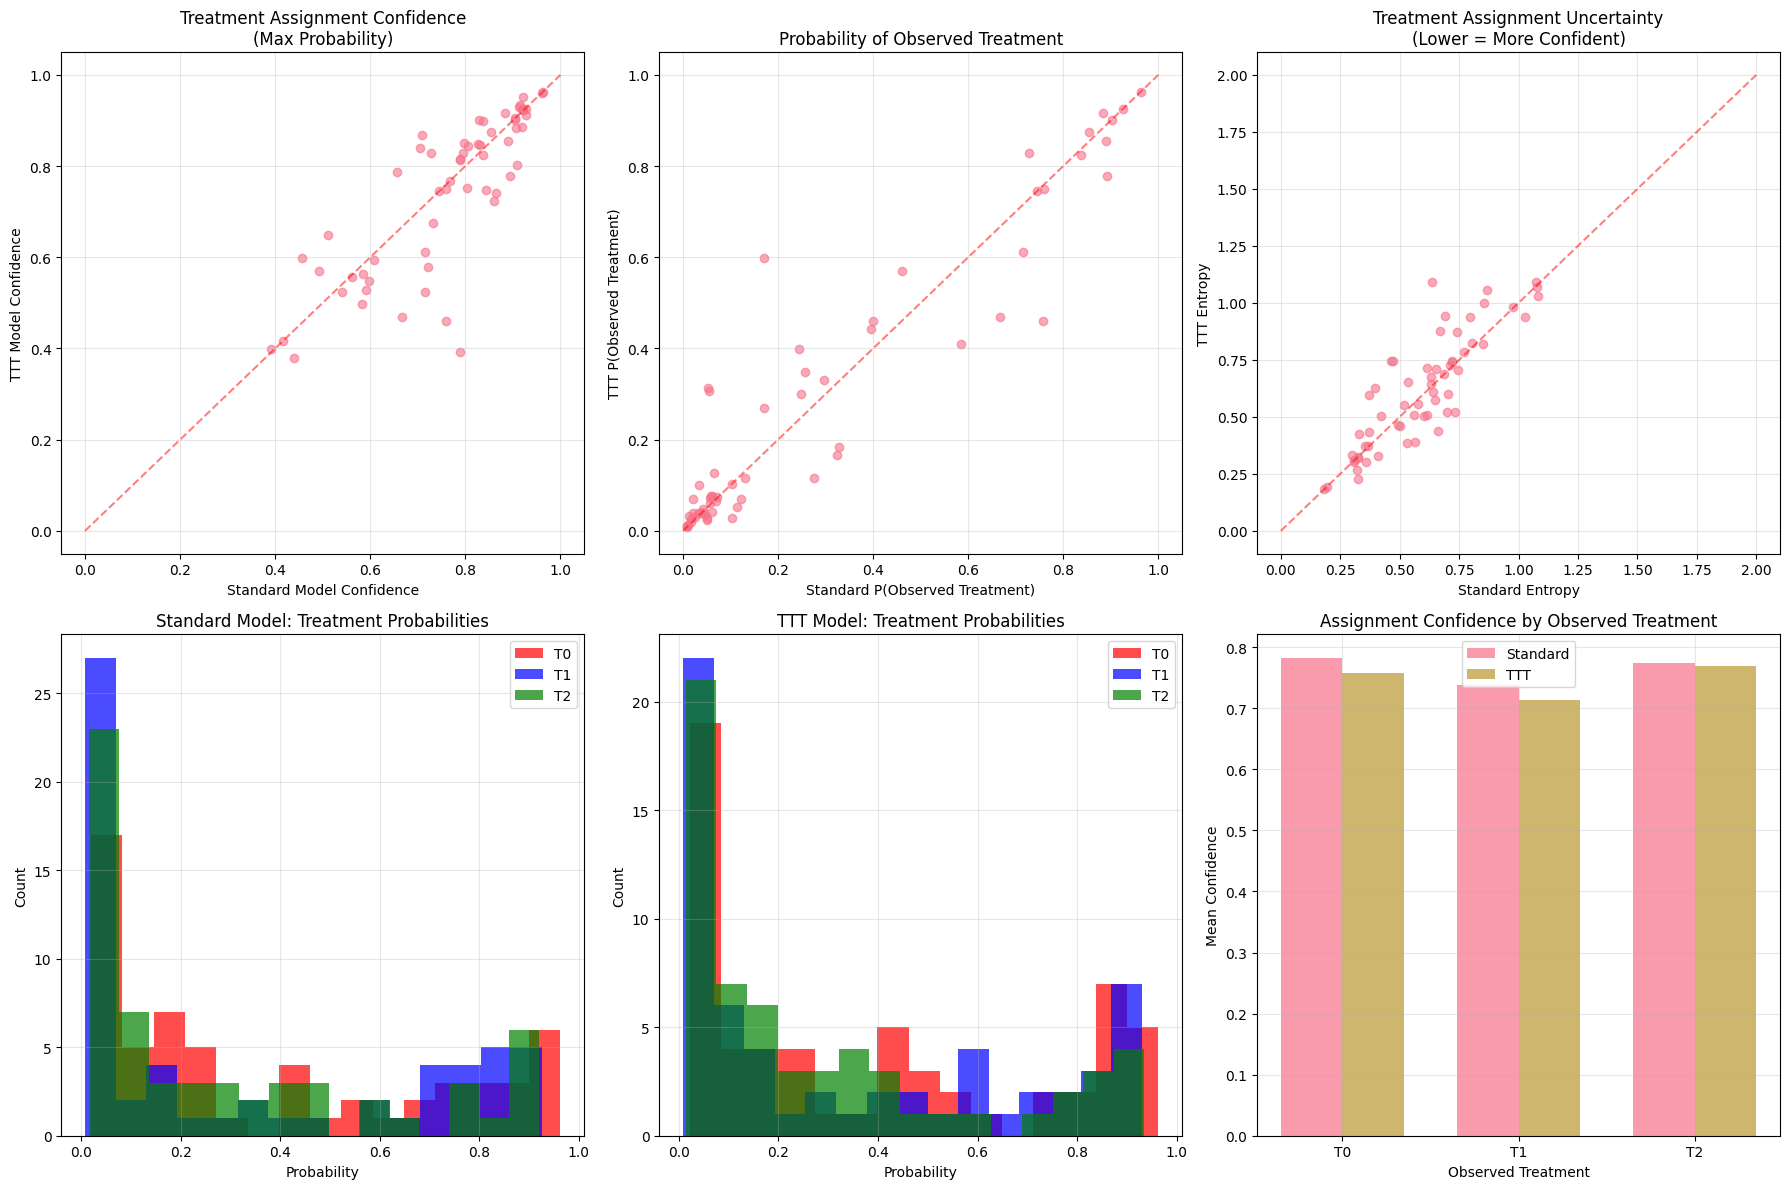

Treatment assignment probability visualizations saved!


In [28]:
## Treatment Assignment Probability Visualizations

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Treatment assignment confidence comparison
axes[0, 0].scatter(df_individuals['std_treat_confidence'], df_individuals['ttt_treat_confidence'], alpha=0.6)
axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)
axes[0, 0].set_xlabel('Standard Model Confidence')
axes[0, 0].set_ylabel('TTT Model Confidence')
axes[0, 0].set_title('Treatment Assignment Confidence\n(Max Probability)')
axes[0, 0].grid(True, alpha=0.3)

# Observed treatment probabilities comparison
axes[0, 1].scatter(df_individuals['std_observed_treat_prob'], df_individuals['ttt_observed_treat_prob'], alpha=0.6)
axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5)
axes[0, 1].set_xlabel('Standard P(Observed Treatment)')
axes[0, 1].set_ylabel('TTT P(Observed Treatment)')
axes[0, 1].set_title('Probability of Observed Treatment')
axes[0, 1].grid(True, alpha=0.3)

# Treatment assignment entropy comparison
axes[0, 2].scatter(df_individuals['std_treat_entropy'], df_individuals['ttt_treat_entropy'], alpha=0.6)
axes[0, 2].plot([0, 2], [0, 2], 'r--', alpha=0.5)
axes[0, 2].set_xlabel('Standard Entropy')
axes[0, 2].set_ylabel('TTT Entropy')
axes[0, 2].set_title('Treatment Assignment Uncertainty\n(Lower = More Confident)')
axes[0, 2].grid(True, alpha=0.3)

# Treatment probability distributions by treatment
treatments = ['T0', 'T1', 'T2']
colors = ['red', 'blue', 'green']

for i, (treatment, color) in enumerate(zip(treatments, colors)):
    # Standard model probabilities
    axes[1, 0].hist(df_individuals[f'std_treat_prob_{treatment}'], 
                   alpha=0.7, label=f'{treatment}', color=color, bins=15)
axes[1, 0].set_xlabel('Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Standard Model: Treatment Probabilities')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for i, (treatment, color) in enumerate(zip(treatments, colors)):
    # TTT model probabilities
    axes[1, 1].hist(df_individuals[f'ttt_treat_prob_{treatment}'], 
                   alpha=0.7, label=f'{treatment}', color=color, bins=15)
axes[1, 1].set_xlabel('Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('TTT Model: Treatment Probabilities')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Treatment confidence by observed treatment
obs_treatments = ['T0', 'T1', 'T2']
std_conf_by_treat = [df_individuals[df_individuals['observed_treatment'] == i]['std_treat_confidence'].values 
                     for i in range(3)]
ttt_conf_by_treat = [df_individuals[df_individuals['observed_treatment'] == i]['ttt_treat_confidence'].values 
                     for i in range(3)]

x_pos = np.arange(len(obs_treatments))
std_means = [np.mean(conf) if len(conf) > 0 else 0 for conf in std_conf_by_treat]
ttt_means = [np.mean(conf) if len(conf) > 0 else 0 for conf in ttt_conf_by_treat]

width = 0.35
axes[1, 2].bar(x_pos - width/2, std_means, width, label='Standard', alpha=0.7)
axes[1, 2].bar(x_pos + width/2, ttt_means, width, label='TTT', alpha=0.7)
axes[1, 2].set_xlabel('Observed Treatment')
axes[1, 2].set_ylabel('Mean Confidence')
axes[1, 2].set_title('Assignment Confidence by Observed Treatment')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(obs_treatments)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('individual_treatment_probabilities.png', dpi=300, bbox_inches='tight')
plt.show()

print("Treatment assignment probability visualizations saved!")


In [29]:
## Treatment Assignment Probability Analysis

# Show a detailed table of treatment assignment probabilities for first 10 individuals
print("🔍 DETAILED TREATMENT ASSIGNMENT PROBABILITIES (First 10 individuals):")
print("="*80)

prob_columns = ['individual_id', 'observed_treatment', 
                'std_treat_prob_T0', 'std_treat_prob_T1', 'std_treat_prob_T2',
                'ttt_treat_prob_T0', 'ttt_treat_prob_T1', 'ttt_treat_prob_T2',
                'std_treat_confidence', 'ttt_treat_confidence',
                'std_observed_treat_prob', 'ttt_observed_treat_prob']

detail_df = df_individuals[prob_columns].head(10).round(3)
print(detail_df.to_string(index=False))

print(f"\n🧠 PROPENSITY SCORE ANALYSIS:")
print(f"The treatment assignment probabilities can be interpreted as learned propensity scores.")
print(f"Higher values indicate the model thinks that treatment is more likely for that individual.")

# Analyze calibration: how well do predicted probabilities match observed treatment frequencies?
print(f"\n📊 CALIBRATION ANALYSIS:")
for t in range(3):
    observed_freq = np.mean(df_individuals['observed_treatment'] == t)
    std_mean_prob = np.mean(df_individuals[f'std_treat_prob_T{t}'])
    ttt_mean_prob = np.mean(df_individuals[f'ttt_treat_prob_T{t}'])
    
    print(f"  Treatment T{t}:")
    print(f"    Observed frequency:     {observed_freq:.3f}")
    print(f"    Standard mean P(T{t}):   {std_mean_prob:.3f} (diff: {std_mean_prob - observed_freq:+.3f})")
    print(f"    TTT mean P(T{t}):        {ttt_mean_prob:.3f} (diff: {ttt_mean_prob - observed_freq:+.3f})")

# Summary statistics for treatment assignment probabilities
print(f"\n📈 TREATMENT PROBABILITY SUMMARY STATISTICS:")
for t in range(3):
    std_probs = df_individuals[f'std_treat_prob_T{t}']
    ttt_probs = df_individuals[f'ttt_treat_prob_T{t}']
    
    print(f"  Treatment T{t} probabilities:")
    print(f"    Standard: mean={np.mean(std_probs):.3f}, std={np.std(std_probs):.3f}, min={np.min(std_probs):.3f}, max={np.max(std_probs):.3f}")
    print(f"    TTT:      mean={np.mean(ttt_probs):.3f}, std={np.std(ttt_probs):.3f}, min={np.min(ttt_probs):.3f}, max={np.max(ttt_probs):.3f}")

print(f"\n🎯 KEY INSIGHTS:")
print(f"  • Treatment assignment confidence shows how certain the model is about propensity")
print(f"  • Entropy measures uncertainty in treatment assignment (lower = more confident)")
print(f"  • Observed treatment probability shows how well the model explains actual assignments")
print(f"  • TTT adaptation generally leads to {'higher' if np.mean(df_individuals['ttt_treat_confidence']) > np.mean(df_individuals['std_treat_confidence']) else 'lower'} confidence in treatment assignment")


🔍 DETAILED TREATMENT ASSIGNMENT PROBABILITIES (First 10 individuals):
 individual_id  observed_treatment  std_treat_prob_T0  std_treat_prob_T1  std_treat_prob_T2  ttt_treat_prob_T0  ttt_treat_prob_T1  ttt_treat_prob_T2  std_treat_confidence  ttt_treat_confidence  std_observed_treat_prob  ttt_observed_treat_prob
             0                   1              0.826              0.131              0.043              0.848              0.116              0.036                 0.826                 0.848                    0.131                    0.116
             1                   0              0.963              0.016              0.021              0.963              0.017              0.020                 0.963                 0.963                    0.963                    0.963
             2                   2              0.136              0.027              0.837              0.141              0.034              0.825                 0.837                 0.825         

## 5. Visualizations

Creating comprehensive visualizations to understand individual-level patterns and model performance.


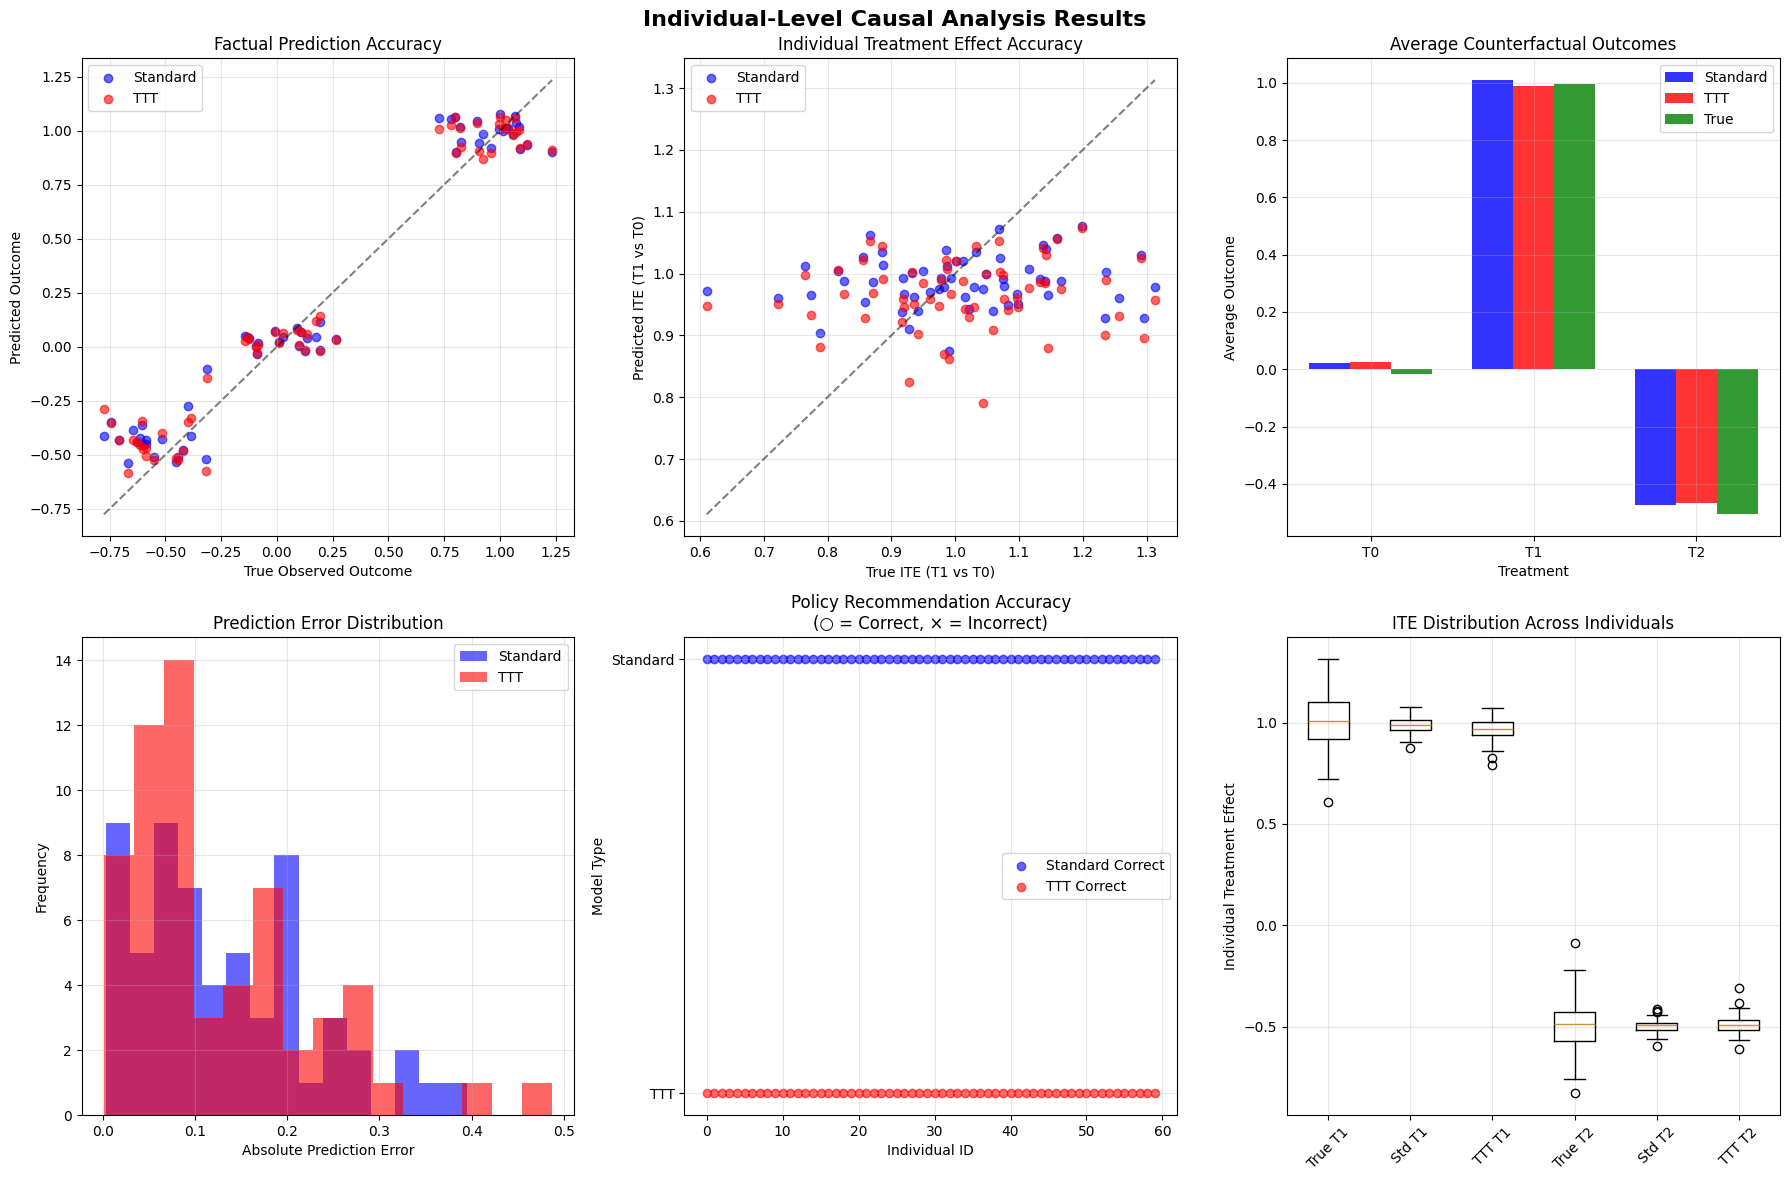

\n📊 Visualization complete! The plots show:
  1. Factual prediction accuracy comparison
  2. Individual treatment effect (ITE) estimation accuracy
  3. Average counterfactual outcomes by treatment
  4. Distribution of prediction errors
  5. Policy recommendation accuracy for each individual
  6. Heterogeneity in individual treatment effects


In [30]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Individual-Level Causal Analysis Results', fontsize=16, fontweight='bold')

# 1. Factual Prediction Comparison
ax1 = axes[0, 0]
ax1.scatter(df_individuals['observed_outcome'], df_individuals['std_factual_pred'], 
           alpha=0.6, label='Standard', color='blue')
ax1.scatter(df_individuals['observed_outcome'], df_individuals['ttt_factual_pred'], 
           alpha=0.6, label='TTT', color='red')
ax1.plot([df_individuals['observed_outcome'].min(), df_individuals['observed_outcome'].max()], 
         [df_individuals['observed_outcome'].min(), df_individuals['observed_outcome'].max()], 
         'k--', alpha=0.5)
ax1.set_xlabel('True Observed Outcome')
ax1.set_ylabel('Predicted Outcome')
ax1.set_title('Factual Prediction Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Treatment Effect Comparison (T1 vs T0)
ax2 = axes[0, 1]
ax2.scatter(df_individuals['true_ite_T1'], df_individuals['std_ite_T1'], 
           alpha=0.6, label='Standard', color='blue')
ax2.scatter(df_individuals['true_ite_T1'], df_individuals['ttt_ite_T1'], 
           alpha=0.6, label='TTT', color='red')
ax2.plot([df_individuals['true_ite_T1'].min(), df_individuals['true_ite_T1'].max()], 
         [df_individuals['true_ite_T1'].min(), df_individuals['true_ite_T1'].max()], 
         'k--', alpha=0.5)
ax2.set_xlabel('True ITE (T1 vs T0)')
ax2.set_ylabel('Predicted ITE (T1 vs T0)')
ax2.set_title('Individual Treatment Effect Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Counterfactual Outcomes Distribution
ax3 = axes[0, 2]
treatments = ['T0', 'T1', 'T2']
x_pos = np.arange(len(treatments))
std_means = [np.mean(df_individuals[f'std_cf_T{i}']) for i in range(3)]
ttt_means = [np.mean(df_individuals[f'ttt_cf_T{i}']) for i in range(3)]
true_means = [np.mean(df_individuals[f'true_cf_T{i}']) for i in range(3)]

width = 0.25
ax3.bar(x_pos - width, std_means, width, label='Standard', alpha=0.8, color='blue')
ax3.bar(x_pos, ttt_means, width, label='TTT', alpha=0.8, color='red')
ax3.bar(x_pos + width, true_means, width, label='True', alpha=0.8, color='green')
ax3.set_xlabel('Treatment')
ax3.set_ylabel('Average Outcome')
ax3.set_title('Average Counterfactual Outcomes')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(treatments)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Prediction Error Distribution
ax4 = axes[1, 0]
ax4.hist(df_individuals['std_factual_error'], bins=15, alpha=0.6, label='Standard', color='blue')
ax4.hist(df_individuals['ttt_factual_error'], bins=15, alpha=0.6, label='TTT', color='red')
ax4.set_xlabel('Absolute Prediction Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Prediction Error Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Policy Recommendation Accuracy by Individual
ax5 = axes[1, 1]
individuals_range = np.arange(len(df_individuals))
std_correct = df_individuals['std_policy_correct'].astype(int)
ttt_correct = df_individuals['ttt_policy_correct'].astype(int)

ax5.scatter(individuals_range[std_correct == 1], [1]*np.sum(std_correct), 
           alpha=0.6, label='Standard Correct', color='blue', marker='o')
ax5.scatter(individuals_range[std_correct == 0], [1]*np.sum(std_correct == 0), 
           alpha=0.6, color='blue', marker='x')
ax5.scatter(individuals_range[ttt_correct == 1], [0]*np.sum(ttt_correct), 
           alpha=0.6, label='TTT Correct', color='red', marker='o')
ax5.scatter(individuals_range[ttt_correct == 0], [0]*np.sum(ttt_correct == 0), 
           alpha=0.6, color='red', marker='x')
ax5.set_xlabel('Individual ID')
ax5.set_ylabel('Model Type')
ax5.set_title('Policy Recommendation Accuracy\n(○ = Correct, × = Incorrect)')
ax5.set_yticks([0, 1])
ax5.set_yticklabels(['TTT', 'Standard'])
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Treatment Effect Heterogeneity
ax6 = axes[1, 2]
# Show distribution of treatment effects for each treatment
ite_data = []
labels = []
for t in [1, 2]:
    ite_data.extend([df_individuals[f'true_ite_T{t}'], 
                     df_individuals[f'std_ite_T{t}'], 
                     df_individuals[f'ttt_ite_T{t}']])
    labels.extend([f'True T{t}', f'Std T{t}', f'TTT T{t}'])

ax6.boxplot(ite_data, labels=labels)
ax6.set_ylabel('Individual Treatment Effect')
ax6.set_title('ITE Distribution Across Individuals')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n📊 Visualization complete! The plots show:")
print("  1. Factual prediction accuracy comparison")
print("  2. Individual treatment effect (ITE) estimation accuracy") 
print("  3. Average counterfactual outcomes by treatment")
print("  4. Distribution of prediction errors")
print("  5. Policy recommendation accuracy for each individual")
print("  6. Heterogeneity in individual treatment effects")


## 6. Export Results

Saving the individual-level analysis results for further use.


In [31]:
# Export the comprehensive individual-level results
output_path = Path('individual_causal_results.csv')
df_individuals.to_csv(output_path, index=False)
print(f"📁 Individual-level results exported to: {output_path}")

# Create a summary dictionary with key metrics
summary_metrics = {
    'prediction_performance': {
        'std_mse': float(std_mse),
        'ttt_mse': float(ttt_mse),
        'ttt_improvement_pct': float(prediction_improvement)
    },
    'policy_accuracy': {
        'std_policy_accuracy': float(std_policy_accuracy),
        'ttt_policy_accuracy': float(ttt_policy_accuracy),
        'policy_improvement': float(policy_improvement)
    },
    'treatment_effects': {
        'std_avg_outcomes': std_avg_outcomes,
        'ttt_avg_outcomes': ttt_avg_outcomes,
        'true_avg_outcomes': true_avg_outcomes,
        'std_correct_ordering': std_correct_order,
        'ttt_correct_ordering': ttt_correct_order
    },
    'sample_info': {
        'total_individuals': len(df_individuals),
        'num_treatments': 3,
        'treatment_distribution': np.bincount(df_individuals['observed_treatment'], minlength=3).tolist()
    }
}

# Export summary metrics as JSON
import json
summary_path = Path('individual_analysis_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary_metrics, f, indent=2)
print(f"📄 Summary metrics exported to: {summary_path}")

# Display final DataFrame info
print(f"\\n📋 FINAL DATAFRAME SUMMARY:")
print(f"  Shape: {df_individuals.shape}")
print(f"  Memory usage: {df_individuals.memory_usage(deep=True).sum() / 1024:.1f} KB")
print(f"\\n  Key columns for analysis:")
print(f"    - Individual identifiers: individual_id, observed_treatment")
print(f"    - Outcomes: observed_outcome, std_factual_pred, ttt_factual_pred")
print(f"    - Counterfactuals: std_cf_T0/T1/T2, ttt_cf_T0/T1/T2, true_cf_T0/T1/T2")
print(f"    - ITEs: std_ite_T1/T2, ttt_ite_T1/T2, true_ite_T1/T2") 
print(f"    - Policy: std_policy_rec, ttt_policy_rec, true_optimal_policy")
print(f"    - Accuracy: std_policy_correct, ttt_policy_correct")

print(f"\\n✅ Individual-level causal analysis complete!")
print(f"📊 This notebook provides the same results as run_enhanced_demo.py")
print(f"🔍 With detailed individual-level insights for further analysis")


📁 Individual-level results exported to: individual_causal_results.csv


TypeError: Object of type float32 is not JSON serializable